In [1]:
%matplotlib widget
import numpy as np
import json, glob, copy
import os, math
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
from datetime import datetime

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.timing_tool import *
from alvra_tools.utils import *
from alvra_tools.YAG_scans import *
from alvra_tools.XAS_functions import *
from ipyfilechooser import FileChooser

import warnings
warnings.filterwarnings('ignore')

## choose run number

In [2]:
pgroup='p21210'
runnumber = 19
print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str( pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0019


'/sf/alvra/data/p21210/raw/run0019-Timescan_YAG/meta/scan.json'

In [3]:
TT = TT_PSEN126

quantile_band = 0.5

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Claudio/Reduced_YAG_TT/'
saveflag = True

########################################
#YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
#YAG_scan_one_TT_bs(json_file, TT, channel_delay_motor, timezero_mm, quantile, filterTime=2000, filterAmp=0):
########################################
flag = True

try:
    Timezero_mm = get_timezero_NBS(jsonfile)
    flag = True
except:
    Timezero_mm = Timezero_mm

from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)
    
Delay_rbk, Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

if saveflag:
    os.makedirs(reducedir+run_name, exist_ok=True)
    save_run_array_YAG_TT(reducedir, run_name, Delay_rbk, Delay_fs, Delays_corr,
                   Pump_probe, Pump_probe_scan)

print ('------------------------------')
if flag:
    print ('Timezero found in file = {} mm'.format(Timezero_mm))
else:
    print ('Timezero = {} mm'.format(Timezero_mm))

    #Delays_corr -= Delay_fs

#pp_uncorrected = Pump_probe[:,0]
#err_pp_low = Pump_probe[:,1]
#err_pp_high = Pump_probe[:,2]

Processing: run0019-Timescan_YAG
Step 41 of 41: Processing acq0041

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                495 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 495 / 501 -> 1% loss
c

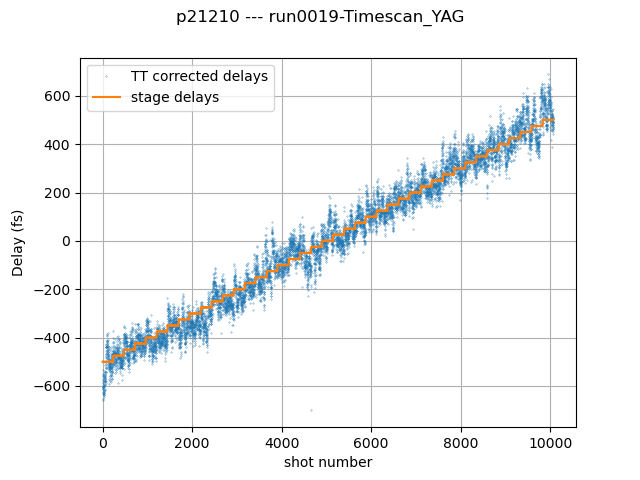

In [4]:
plt.figure()
plt.suptitle(titlestring)
plt.plot(Delays_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.grid()
plt.show()

## Re-bin the data with chosen binsize

In [5]:
binsize = 20 # in fs

min_delay = -500
max_delay = 500

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic=np.nanmean, bins=binList)

(10070,) (10070,)


## Choose fit function

In [6]:
# err function ---------------> [x0, amplitude, width, offset]
# exp_gauss_heaviside --------> [x0, amplitude, width, offset, lifetime]
# conv_exp_gauss_heaviside2 --> [x0, amplitude, width, offset, lifetime, a, b]

fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
#fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
#fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)

## Do the fit

In [7]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
#fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

(-10.0, 0.030158278179168902, 20.0, -0.0034455807250087186)
(-10.0, 0.030158278179168902, 20.0, -0.0034455807250087186)
Position t0 = 172.94681 mm
Width = 139.67109 fs


## Plot

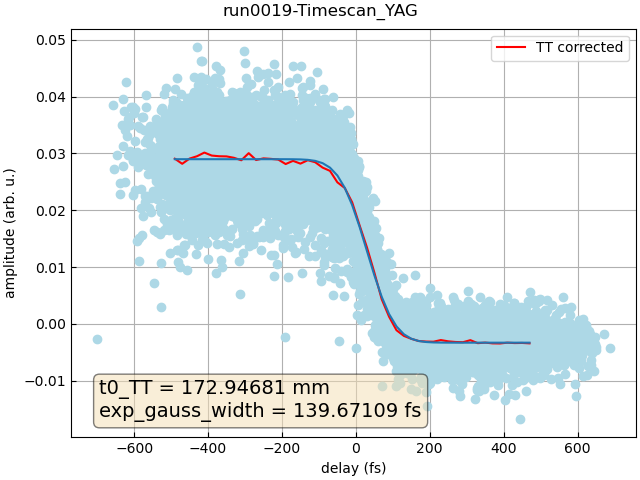

Position t0_raw = 172.942320000045 mm
Position t0_TT = 172.94681417352618 mm


In [8]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(jsonfile.split('/')[-3] )#+ " mono")

plt.tick_params(direction='in')

plt.plot(Delays_corr, Pump_probe_scan, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'exp_gauss_width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
#plt.ylim(-0.05, 0.2)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

# fit with pseudo-voigt

[[Model]]
    Model(pvoigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 225
    # variables        = 4
    chi-square         = 5.3407e-06
    reduced chi-square = 2.4166e-08
    Akaike info crit   = -3942.15587
    Bayesian info crit = -3928.49147
[[Variables]]
    amplitude: -1.66735844 +/- 3055239.55 (183238317.44%) (init = 20)
    center:     9.88628182 +/- 0.44959671 (4.55%) (init = 10)
    sigma:      0.00829245 +/- 960.753886 (11585885.22%) (init = 0.54)
    fraction:   0.57790569 +/- 1041305.45 (180186051.80%) (init = 0.5)
    fwhm:       0.01658490 +/- 1921.50777 (11585885.23%) == '2.0000000*sigma'
    height:    -76.8524873 +/- 1.7519e+08 (227962582.56%) == '(((1-fraction)*amplitude)/max(1e-15, (sigma*sqrt(pi/log(2))))+(fraction*amplitude)/max(1e-15, (pi*sigma)))'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, fraction) =  0.998
    C(center, sigma)       = -0.657
    C(amplitude, sigma)    

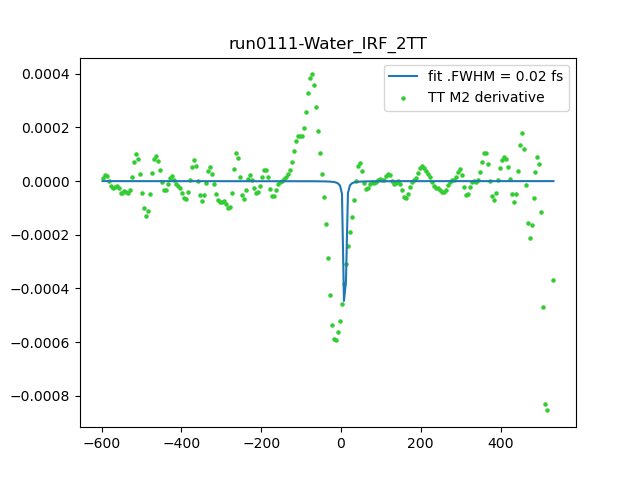

In [656]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)

mod = PseudoVoigtModel()

pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)

# create a set of Parameters
#params = Parameters()

init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=20.0, center=10, sigma=0.54, fraction=0.5, x=Delay_fs_TT)

plt.figure()
plt.title(jsonfile.split('/')[-3])
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
#plt.plot(Delay_fs_TT, out.init_fit, '--', label='initial fit')
plt.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit .FWHM = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
plt.legend()
print(out.fit_report())

#lt.plot(Delay_fs_TT,peak1-172.31)
#

    

Delay Pump Topas as delay# fit with Gaussian

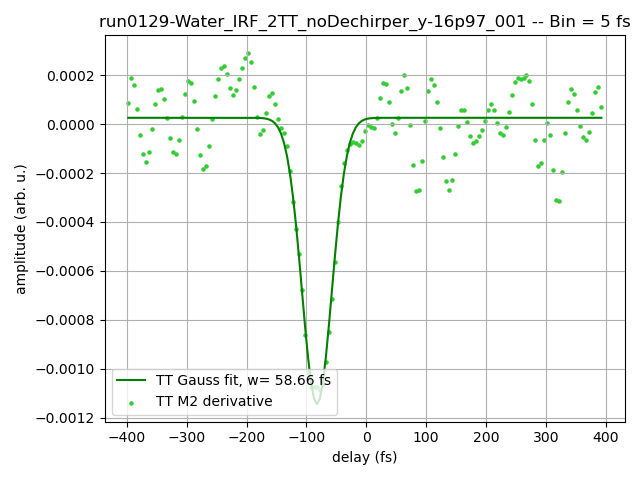

[-8.24848445e+01 -1.17157088e-03 -2.49069309e+01  2.62956910e-05]


In [753]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-55, 0])

plt.figure()
plt.title(jsonfile.split('/')[-3]+ ' -- Bin = {} fs'.format(binsize))
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT Gauss fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

print(parameters_M2)

In [337]:
def load_reduced_data(pgroup, loaddir, runlist):
    from collections import defaultdict
    titlestring = pgroup + ' --- ' +str(runlist)

    d = defaultdict(list)
    for run in runlist:
        data = {}
        file = glob.glob(loaddir + '/*{:04d}*/*run_array*'.format(run))
        run_array = np.load(file[0], allow_pickle=True).item()
        for k, v in run_array.items():
            for key, value in v.items():
                data[key] = value
                d[key].extend(value)
                # if "scan" in key:
                #     d[key].extend(value)
                # else:
                #     d[key].extend(value)
    return d, titlestring

In [740]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_TT'

runlist1=np.arange(124, 126)
runlist2=np.arange(127, 129)
runlist= list(runlist1)+list(runlist2)
##############################################
from textwrap import wrap
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
scan = SFScanInfo(firstrun)

data, titlestring_stack = load_reduced_data(pgroup, Loaddir, runlist)

globals().update(data)
print (runlist)
print ('{} scans, {} total shots'.format(len(runlist), len(Delay_corr)))


[124, 125, 127, 128]
4 scans, 79083 total shots


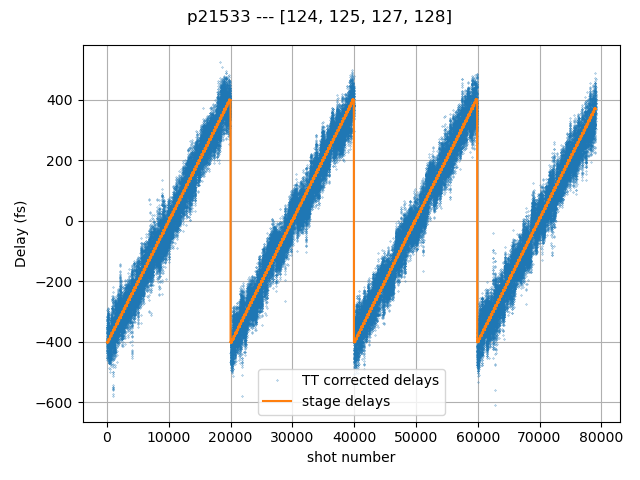

In [741]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(Delay_corr, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(Delay_fs, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.tight_layout()
plt.grid()
plt.show()

In [742]:
binsize = 2 # in fs

min_delay = -400
max_delay = 400

#####################################################################################################
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delay_corr))

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2

Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delay_corr, Pump_probe_scan, statistic=np.nanmean, bins=binList)

(79083,) (79083,)


In [743]:
index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
Delay_fs_TT = Delay_fs_TT[index]
pp_TT=  pp_TT[index]

fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
print(fit.p0)
fit.p0 = better_p0(fit.p0, 4,200)# overwrite some values (index) if needed: 
#fit.p0 =[0, 0.04, 50, 0.0, 500, 3e-5, 0.035]
#fit.p0 =[0, 0.04, 50, 0.0, 500]
print(fit.p0)

fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting

t0_fs = fit.popt[0]
t0_mm = Timezero_mm + fs2mm(t0_fs, 0)
width_fs = fit.popt[2]

print("Position t0 =",np.round(t0_mm,5),"mm")
#print("Width =",np.abs(np.round(width_mm,3))*1000,"um")
#print("Position t0 =",np.round(t0_fs,5),"fs")
print("Width =",np.abs(np.round(width_fs,5)),"fs")

(-1.0, 0.021649350300237926, 2.0, -0.003960068132660669, 0.25, 0, 0)
(-1.0, 0.021649350300237926, 2.0, -0.003960068132660669, 200, 0, 0)
Position t0 = 202.81659 mm
Width = 95.79749 fs


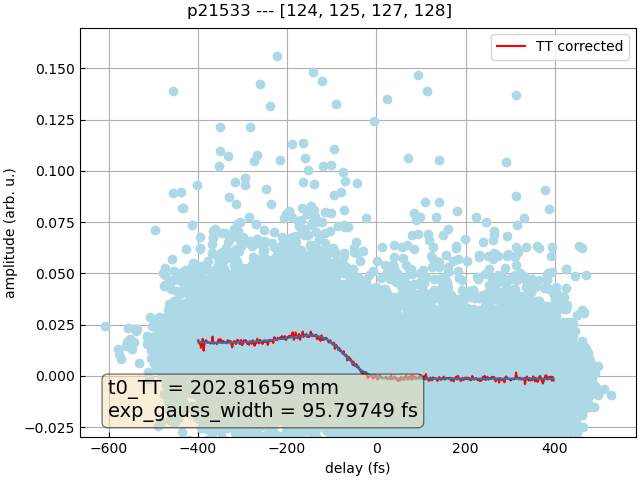

Position t0_raw = 202.82752000004498 mm
Position t0_TT = 202.81658645696666 mm


In [744]:
fig, ax = plt.subplots(constrained_layout=True)
#plt.figure(constrained_layout=True)
plt.suptitle(titlestring_stack)

plt.tick_params(direction='in')

plt.plot(Delay_corr, Pump_probe_scan, 'o', color='lightblue')#, markersize=0.5)
# plt.plot(Delay_fs, pp_uncorrected, marker='.',label = 'raw scan, t0 = {} mm'.format(timezero_mm))
plt.plot(Delay_fs_TT, pp_TT, color='red', label = 'TT corrected')
plt.plot(Delay_fs_TT, pp_fit)

boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((#r'Delta_t0 = {} fs'.format(np.round(t0_fs, 5)),
                     r't0_TT = {} mm'.format(np.round(Timezero_mm + fs2mm(t0_fs,0),5)),
            r'exp_gauss_width = {} fs'.format(np.abs(np.round(width_fs, decimals = 5)))))
plt.text(0.05, 0.05, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.legend (loc = 'upper right')
plt.ylim(-0.03, 0.17)
#plt.xlim(-600, 600)
plt.grid()
plt.show()

print("Position t0_raw = {} mm".format(Timezero_mm ))
print("Position t0_TT = {} mm".format(Timezero_mm + fs2mm(t0_fs,0)))

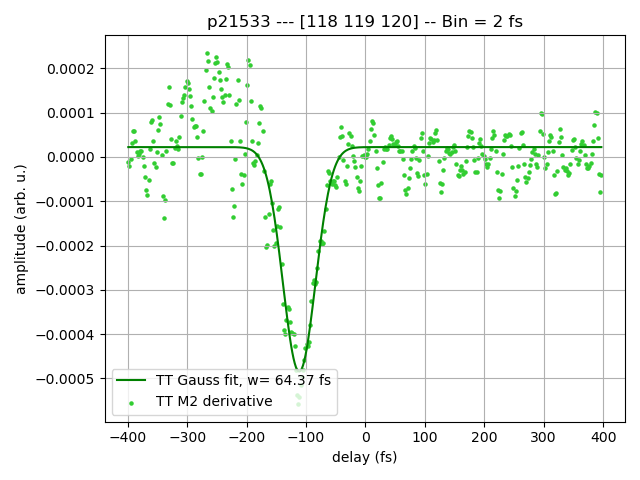

[-1.11459784e+02 -5.07123045e-04 -2.73325832e+01  2.23372736e-05]


In [710]:
pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-55, 0])

plt.figure()
plt.title(titlestring_stack+ ' -- Bin = {} fs'.format(binsize))
plt.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
plt.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'TT Gauss fit, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

plt.legend(loc='lower left')

plt.xlabel('delay (fs)')
plt.ylabel('amplitude (arb. u.)')
plt.grid()
plt.tight_layout()
plt.show()

print(parameters_M2)

In [430]:
Delay_1mm = np.copy(Delay_fs_TT)
pp_TT_1mm = np.copy(pp_TT)

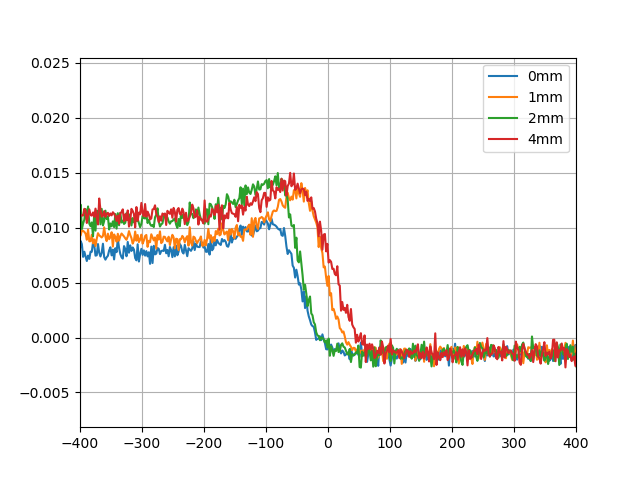

In [431]:
plt.figure()
plt.plot(Delay_0mm, pp_TT_0mm, label='0mm')
plt.plot(Delay_1mm, pp_TT_1mm, label='1mm')
plt.plot(Delay_2mm, pp_TT_2mm, label='2mm')
plt.plot(Delay_4mm, pp_TT_4mm, label='4mm')
plt.legend(loc='best')
plt.grid()
plt.xlim(-400,400)
plt.show()

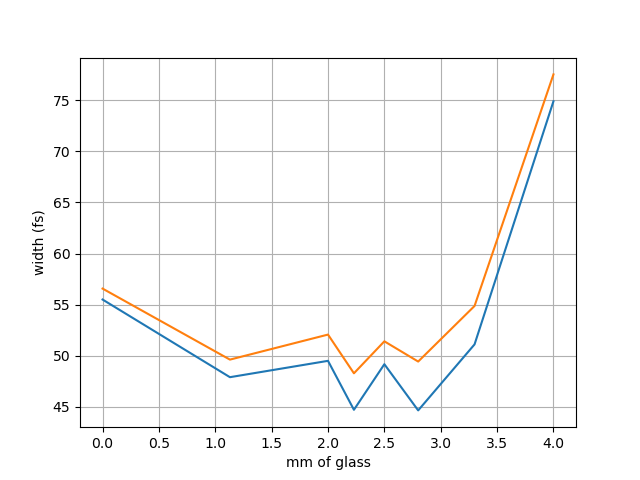

In [570]:
glass =        [0,     1.13,  2,     2.23,  2.5,   2.8,   3.3,   4]
risetime_all = [55.5,  47.9,  49.5,  44.71, 49.17, 44.65, 51.11, 74.9]
risetime_avg = [56.57, 49.62, 52.07, 48.28, 51.41, 49.43, 54.87, 77.53]

plt.figure()
plt.plot(glass, risetime_all)#, s = 20)
plt.plot(glass, risetime_avg)#, s = 20)
# plt.scatter(glass, risetime_all, s = 20)
# plt.scatter(glass, risetime_avg, s = 20)
plt.xlabel('mm of glass')
plt.ylabel('width (fs)')
plt.grid()
plt.show()

# std analysis on rebinned data

In [123]:
binsize = 2 # in fs

################################################################################################3
from scipy.stats import binned_statistic
print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
pp_std, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='std', bins=binList)

(12398,) (12398,)


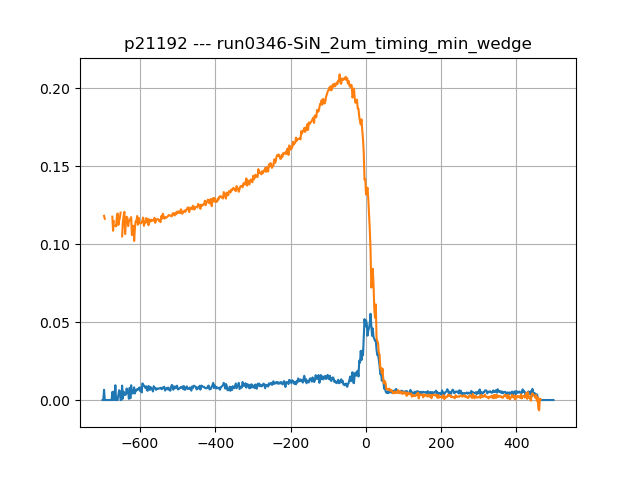

In [29]:
plt.figure()
plt.title(titlestring)
plt.plot(Delay_fs_TT,pp_std)
plt.plot(Delay_fs_TT,pp_TT)
plt.grid()
plt.show()

# Load & plot data (rebinned)

In [400]:
#unlist = np.arange(13, 25, 1)
runlist = [23, 29, 30]

Loaddir = '../Claudio/Reduced_YAG_TT/'
##############################################
import glob
print ('Will load {} runs: {} from {}'.format(len(runlist), runlist, Loaddir))
check = []
for run in runlist:
    try:
        check.append(glob.glob(Loaddir + '/*{:04d}*/*run_array*npy*'.format(run))[0])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [23, 29, 30] from ../Claudio/Reduced_YAG_TT/


['../Claudio/Reduced_YAG_TT/run0023-SiN_scan_5p5keV_stage20_dechirper/run_array.npy',
 '../Claudio/Reduced_YAG_TT/run0029-SiN_scan_5p5keV_p0/run_array.npy',
 '../Claudio/Reduced_YAG_TT/run0030-SiN_scan_5p5keV_14bouces/run_array.npy']

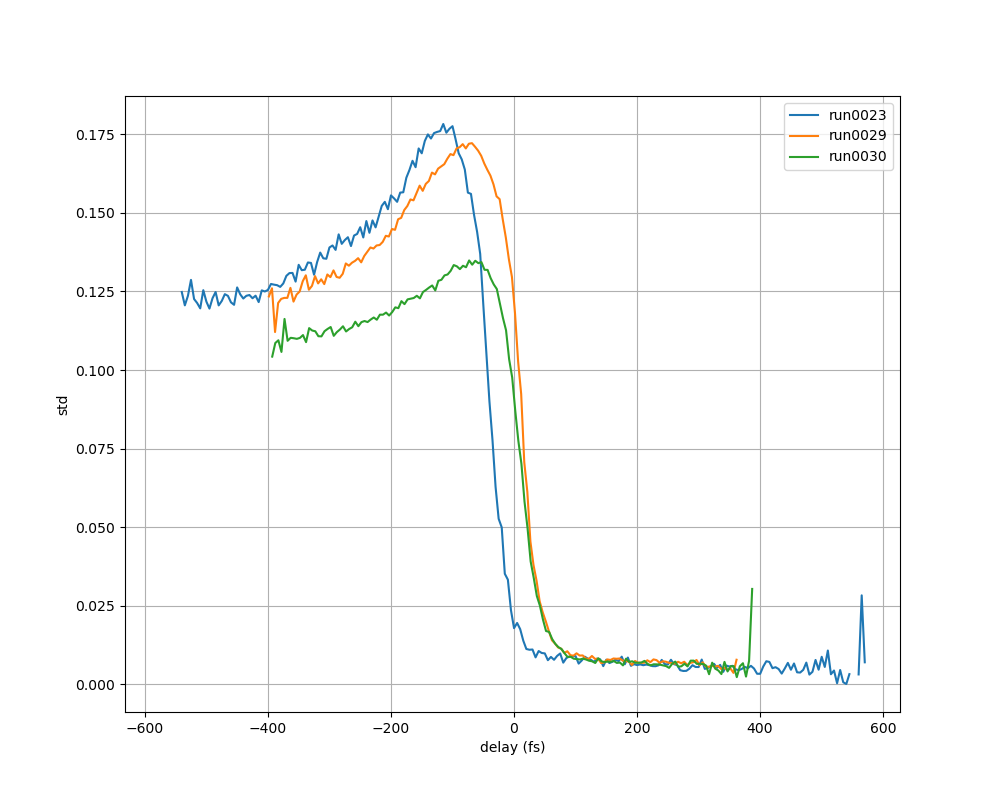

In [401]:
binsize = 5 # in fs

from scipy.stats import binned_statistic
plt.figure(figsize=(10,8))

for index, run in enumerate(runlist):
    path = glob.glob(Loaddir + '/*{:04d}*/'.format(run))
    run_array = np.load(path[0]+'run_array.npy', allow_pickle=True).item()
    for key in run_array.keys():
        runnumber = run_array[key]["name"].split('-')[0]
        Delay_rbk = run_array[key]["Delay_rbk"]
        Delay_fs = run_array[key]["Delay_fs"]
        Pump_probe_scan = run_array[key]["Pump_probe_scan"]
        Delays_corr = run_array[key]["Delay_corr"]
        
        binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
        Delay_fs_TT = np.arange(Delay_fs[0] - 100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

        pp_std, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='std', bins=binList)
        pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
                
#        plt.plot(delays_rbk, (sigma_pump/sigma_unpump), label = runnumber)
#        plt.plot(Delay_fs_TT+Delay_rbk[0], pp_std/np.nanmax(pp_TT), label = runnumber)
#        plt.plot(Delay_fs_TT+Delay_rbk[0], pp_std, label = runnumber)
#        plt.plot(Delay_fs_TT, pp_TT, label = runnumber)
        if (runnumber=='run0023'):
            Delay_fs_TT+=20
        plt.plot(Delay_fs_TT, pp_TT, label = runnumber)

plt.grid()
plt.ylabel('std')
plt.xlabel("delay (fs)")
plt.legend(loc = 'best')
plt.show()


# Loop over several runs

In [635]:
pgroup = 'p21533'
Loaddir_name = 'Reduced_YAG_TT'

runlist=np.arange(100, 110)

##############################################
Loaddir = '/sf/alvra/data/{}/work/Claudio/{}/'.format(pgroup, Loaddir_name)
#firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
#scan = SFScanInfo(firstrun)
titlestring_stack = pgroup + ' --- ' +str(runlist)
datafiles = []
for runnumber in runlist:
    jsonfile = ''
    jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
    datafiles.append(jsonfile)
datafiles = sorted(datafiles, key = os.path.getmtime)
print (len(datafiles),'files')
#datafiles

10 files


In [736]:
TT = TT_PSEN126

quantile_band = 0.5
binsize = 2 # in fs

min_delay = -700
max_delay = 400

channel_delay_motor = channel_delay_topas

Timezero_mm = 190.045820 ## Put here the value from the fit without TT (from YAG_scans_noTT.ipynb)
reducedir='../Claudio/Reduced_YAG_TT/'
saveflag = True

########################################
#YAG_scan_one_TT(json_file, TT, channel_delay_motor, timezero_mm, quantile, target, calibration, filterTime=2000, filterAmp=0):
#YAG_scan_one_TT_bs(json_file, TT, channel_delay_motor, timezero_mm, quantile, filterTime=2000, filterAmp=0):
########################################
binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)

flag = True

from scipy.stats import binned_statistic
from sfdata import SFScanInfo

t0_fs_scan =[]
width_fs_scan_der = []

for num, json_file in enumerate(datafiles):
    print (json_file)
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    run_name = json_file.split('/')[-3]
    
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm

    Delay_rbk, Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)
    
    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
        
    pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
    parameters_der,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan_der.append(np.abs(parameters_der[2]*2.355))
    
    if saveflag:
        os.makedirs(reducedir+run_name, exist_ok=True)
        save_run_array_YAG_TT(reducedir, run_name, Delay_rbk, Delay_fs, Delays_corr,
                       Pump_probe, Pump_probe_scan)

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))

Processing: run0100-Water_IRF_2TT_loop_036
Step 4 of 111: Processing acq0004

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                498 / 501 -> 1% loss ▇▇▇▇▇▇▇▇▇
SLAAR11-LMOT-M451:ENC_1_BS               501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 498 / 501 ->

KeyboardInterrupt: 

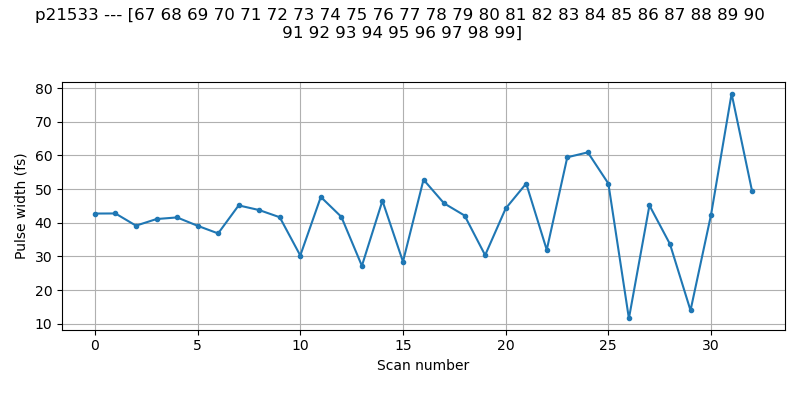

12.353193949643456

In [634]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle (titlestring_stack)


# plt.subplot(121)
# plt.plot(t0_fs_scan, marker='.')
# plt.xlabel("Scan number")
# plt.ylabel('timezero TT (fs)')
# plt.grid()

plt.plot
#plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan_der, marker='.', label = 'Derivative fit')

plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

FWHM_ave=np.mean(width_fs_scan_der)
FWHM_std=np.std(width_fs_scan_der)
#FWHM_ave
FWHM_std


In [38]:
TT = TT_PSEN126

quantile_band = 0.5
binsize = 2 # in fs

channel_delay_motor = channel_delay_topas

Timezero_mm = 108.72812 

flag = False

#target = 'babyYAG'
#px2fs = 1.8692375 ## calibration from 17.10.2021

########################################################################
from sfdata import SFScanInfo
from scipy.stats import binned_statistic

t0_fs_scan =[]
width_fs_scan = []
width_fs_scan_der = []

timestamps_npy = []
timestamps_hms = []

for num, json_file in enumerate(patch):
    scan = SFScanInfo(json_file)
    scan = remove_JF_from_scan(scan)
    
    try:
        Timezero_mm = get_timezero_NBS(json_file)
        flag = True
    except:
        Timezero_mm = Timezero_mm
    
    Delay_fs, Delays_corr, Pump_probe, Pump_probe_scan = \
    YAG_scan_one_TT_bs(scan, TT, channel_delay_motor, Timezero_mm, quantile_band)

    print (np.shape(Pump_probe_scan),np.shape(Delays_corr))

    binList = np.arange(Delay_fs[0] - 100, Delay_fs[-1] + 100, binsize)
    Delay_fs_TT = np.arange(Delay_fs[0] -100 + binsize/2, Delay_fs[-1] + 100 - binsize/2, binsize)

    pp_TT, binEdges, binNumber = binned_statistic(Delays_corr, Pump_probe_scan, statistic='mean', bins=binList)
    
    #fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters) 
    fit = Fit(conv_exp_gauss_heaviside2, estimate_conv_exp_gauss_heaviside2_parameters)
    
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]

    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 

    #fit.p0 = better_p0(fit.p0, 0, 210.42) # overwrite some values (index) if needed:
    #fit.p0 =[191.06, 0.04, 80, 0.0, 500]#, 3e-5, 0.035]
    fit.p0 = better_p0(fit.p0, 4,200)

    
    fit.fit(Delay_fs_TT,pp_TT,maxfev=200000)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
        
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    
    pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
    parameters_der,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0,-50, 0])
    
    t0_fs_scan.append(t0_fs)
    width_fs_scan.append(width_fs)
    width_fs_scan_der.append(np.abs(parameters_der[2]*2.355))
    
    #ax.scatter(Delay_fs_TT, pp_TT_derivative, color=colors[num], s = 5)
    #ax.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_der), color=colors[num],\
    #        label = '{:.2f} fs'.format(np.abs(parameters_der[2]*2.355)))
    
    timestamps_npy.append(timestamp(json_file))
    timestamps_hms.append(timestamp_hms(json_file))

    print ('------------------------------')
    if flag:
        print ('Timezero found in file = {} mm'.format(Timezero_mm))
    else:
        print ('Timezero = {} mm'.format(Timezero_mm))


Processing: run0235-SiN_2um_timing_3p5mmFS_loop_042
Step 88 of 103: Processing acq0088

--------------------------------------------------------------------------------

SAR-CVME-TIFALL5:EvtSet                  501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_amplitude        501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_derivative       501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_position         501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.edge_raw              501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_background 501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.projection_signal     501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY                 25 / 501 -> 95% loss 
SLAAR11-LMOT-M451:ENC_1_BS               501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH0:VAL_GET            501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇
SLAAR11-LSCP1-FNS:CH2:VAL_GET            501 / 501 ->  0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 

ValueError: operands could not be broadcast together with shapes (25,) (0,) 

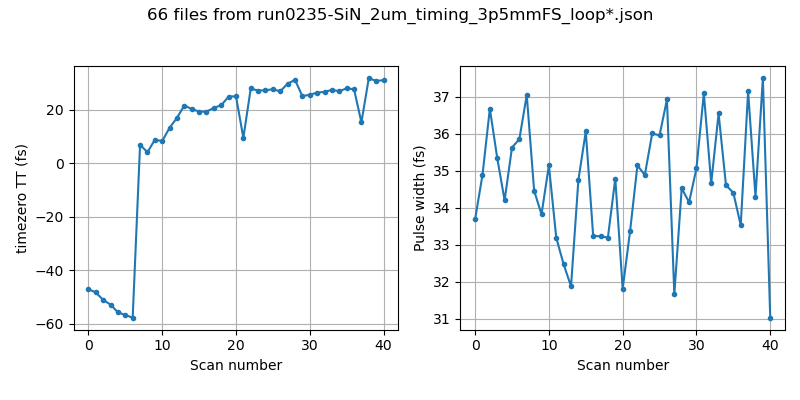

1.597225475519806

In [39]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
#plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))


plt.subplot(121)
plt.plot(t0_fs_scan, marker='.')
plt.xlabel("Scan number")
plt.ylabel('timezero TT (fs)')
plt.grid()

plt.subplot(122)
#plt.plot(width_fs_scan, marker='.', label = 'Convolution fit')
plt.plot(width_fs_scan_der, marker='.', label = 'Derivative fit')

plt.xlabel('Scan number')
plt.ylabel('Pulse width (fs)')
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

FWHM_ave=np.mean(width_fs_scan_der)
FWHM_std=np.std(width_fs_scan_der)
#FWHM_ave
FWHM_std


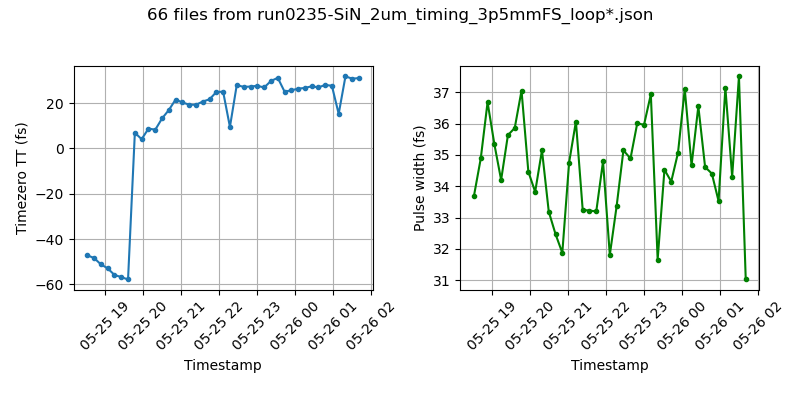

In [42]:
#scan_number = np.delete(np.array(range(123)), [0,65,109,110])

#t0_fs_scan_clean = np.delete(t0_fs_scan[:121], [107,108])
#width_fs_scan_clean = np.delete(width_fs_scan[:121], [107,108])

plt.figure(figsize = (8,4))
plt.suptitle ('{} files from {}'.format(len(patch), json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))
#plt.suptitle ('{} files from {}'.format(79+46, json_file.split('/')[-3].split('.')[0][:-4]+'*.json'))

plt.subplot(121)
plt.plot(timestamps_npy, t0_fs_scan, marker='.')
plt.xlabel("Timestamp")
plt.ylabel('Timezero TT (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.subplot(122)
plt.plot(timestamps_npy, width_fs_scan_der, marker='.', color='g')
plt.xlabel('Timestamp')
plt.ylabel('Pulse width (fs)')
plt.xticks(rotation = 45)
plt.grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##  Timing tool traces & statistics

In [2]:
fc = FileChooser('/sf/alvra/data/p19776/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19776/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [3]:
TT = TT_PSEN126

target = 'babyYAG'
px2fs = 1.8692375 

arrTimes, arrTimesAmp, arrTimes_scan, arrTimesAmp_scan, peaktraces = \
TT_statistics_scan(fc.selected, TT, target, px2fs)

Processing: run0154
Step 61 of 61: Processing acq0061

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet                 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-SPEC125-M1.roi_signal_x_profile 501 / 501 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 501 / 501 -> 0% loss
complete channels: 2 / 2 -> 0% incomplete

--------------------------------------------------------------------------------

Probe rep rate (FEL) is 100.0 Hz
Pump scheme is 1:1
Loaded 250 pump and 250 unpump shots
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)
Sig SARES11-SPEC125-M1.roi_signal_x_profile=(250, 2048)


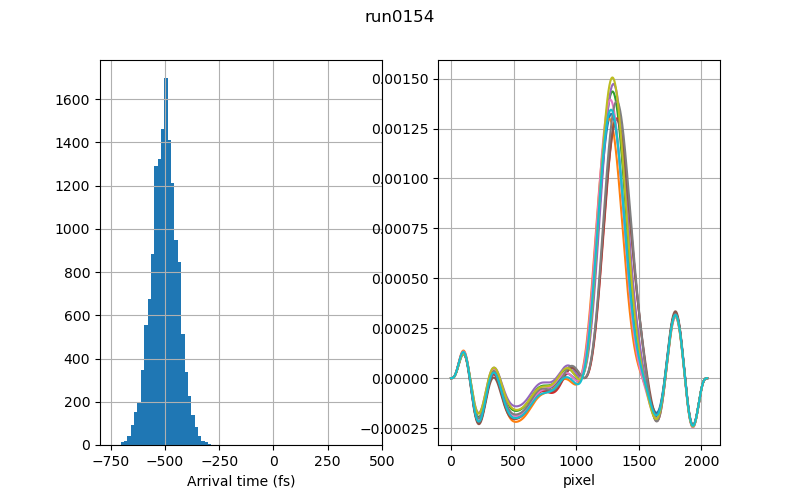

Statistics on all (14543,) shots of the scan
Offset compared to pixel 1024 is -502.3513764672008 fs
Jitter, i.e. width (std) of the histogram 59.857580568151434 fs
--------------------------------------------------------------
Statistics on (250,) shots of the last step of the scan
Offset compared to pixel 1024 is -504.67169415 fs
Jitter, i.e. width (std) of the histogram 44.93531310824471 fs


In [7]:
plt.figure(figsize = (8,5))
plt.subplot(121)
plt.hist(arrTimes_scan, bins=30)
plt.grid()
plt.xlim(-800,500)
plt.xlabel('Arrival time (fs)')

plt.subplot(122)
plt.suptitle (fc.selected.split('/')[-3])
for i in range(10):
   # plt.plot(sigtraces[i][200:1500])
    #plt.plot(pixelNum[100:2047], sigtraces[i][0:1947])
    plt.plot(peaktraces[i])#*10000)
plt.xlabel ('pixel')
#plt.xlim(500,1500)
plt.grid()
plt.show()

print("Statistics on all {} shots of the scan".format(np.shape(arrTimes_scan)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes_scan)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes_scan)))
print("--------------------------------------------------------------")
print("Statistics on {} shots of the last step of the scan".format(np.shape(arrTimes)))
print("Offset compared to pixel 1024 is {} fs".format(np.mean(arrTimes)))
print("Jitter, i.e. width (std) of the histogram {} fs".format(np.std(arrTimes)))


In [ ]:
binsize = 2 # in fs

min_delay = -500
max_delay = 500

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
pp_TT = np.zeros_like(Delay_fs_TT)

howmany = []
for i in range(len(bin_centres)):
    cond1 = Delays_corr >= binList[i]
    cond2 = Delays_corr < binList[i+1]

    idx = np.where(cond1*cond2)[0]
    Delay_fs_TT[i] = np.nanmean(Delays_corr[idx])
    howmany.append(len(idx))
    
    pp_TT[i] = np.nanmean(Pump_probe_scan[idx], axis=0)
